# Tutorial 3

**In this tutorial you will:**
- Build a Chatbot connected to a code interpreter able to execute Python code [Section 1](#1-chatbotwithinterpreter-expanding-interactivity-and-functionality)

In [1]:
%load_ext autoreload
%autoreload 2
#imports
from aiflows.utils.general_helpers import read_yaml_file, quick_load_api_keys
from aiflows.backends.api_info import ApiInfo
from aiflows.utils import serve_utils
from aiflows.utils import colink_utils
from aiflows.workers import run_dispatch_worker_thread
from aiflows.base_flows import AtomicFlow
from aiflows.messages import FlowMessage
from aiflows import flow_verse
import sys
import os
sys.path.append("..")
from utils import compile_and_writefile, dict_to_yaml
import json
import copy
#Specify path of your flow modules


/Users/nicolasbaldwin/opt/miniconda3/envs/mockenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#starting a local colink server
cl = colink_utils.start_colink_server()

In [3]:
# Start Worker thread
run_dispatch_worker_thread(cl)

[2024-03-22 19:27:08,908][aiflows.workers.dispatch_worker:235][INFO] - Dispatch worker started in attached thread.
[2024-03-22 19:27:08,910][aiflows.workers.dispatch_worker:236][INFO] - dispatch_point: coflows_dispatch


In [4]:
# Start 2nd Worker thread (in case you're making blocking calls)
run_dispatch_worker_thread(cl)

[2024-03-22 19:27:09,653][aiflows.workers.dispatch_worker:235][INFO] - Dispatch worker started in attached thread.
[2024-03-22 19:27:09,657][aiflows.workers.dispatch_worker:236][INFO] - dispatch_point: coflows_dispatch


## 1. ChatBotWithInterpreter: Expanding Interactivity and Functionality

In this section, we'll explore the implementation of a chatbot integrated with a code interpreter, offering new dimensions of interactivity and functionality. By connecting an interpreter capable of compiling and executing code to the chatbot, we unlock numerous benefits. This setup enables users to prompt the chatbot with specific tasks, allowing them to provide instructions like "download Apple's stock prices, plot them, and save them in a PDF." In response, the chatbot generates tailored code to execute these tasks, and executes it. 

Additionally, integrating the interpreter enhances the chatbot's adaptability and versatility. By understanding the user's environment, such as their Python environment, the chatbot can execute code seamlessly within that context. This capability extends to installing necessary Python packages on-the-fly, ensuring smooth execution without requiring user intervention. Such integration enhances the chatbot's utility, making it a versatile tool for coding assistance, troubleshooting, and rapid prototyping. Furthermore, this integration ensures that all generated code is compilable, maintaining a seamless user experience and efficient task execution.


### 1.1 Leveraging ChatAtomicFlow to write a CodeGenerator Flow

##### Pulling ChatAtomicFlow from FlowVerse

In [5]:
#Install dependencies from FlowVerse
dependencies = [
    {"url": "aiflows/ChatFlowModule", "revision": "main"},
]
from aiflows import flow_verse
flow_verse.sync_dependencies(dependencies)

[2024-03-22 19:27:13,222][aiflows.flow_verse.loading:775][INFO] - [<interactive>] started to sync flow module dependencies to /Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/4.ChatWithInterpreter/flow_modules...
[2024-03-22 19:27:13,332][aiflows.flow_verse.loading:563][INFO] - aiflows/ChatFlowModule:main will be fetched from remote


Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 48897.33it/s]


[2024-03-22 19:27:13,913][aiflows.flow_verse.loading:825][INFO] - [<interactive>] finished syncing




['/Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/4.ChatWithInterpreter/flow_modules/aiflows/ChatFlowModule']

##### Writing the CodeGenerator's Default Config

In [6]:
#Defining prompt templates

#system prompt template
system_prompt_template = \
"""
You are a world class programmer that can complete any goal with code.
      
Your tasks are:
    1. Write a python code in order to achieve a goal that is given to you. This code should be able to be run by the executor.

Notice that:
    1. If you use any external libraries, you must install them withing the code (in python)
    2. All functions you write are modular, so make sure you make imports necessary imports within the function.
    3. You must write docstrings for every function you write.

    
Your function will then be imported and called by an executor to finish the goal, you do not need to worry about the execution part.
The executor will give you feedback on the code you write, and you can revise your code based on the feedback.

Performance Evaluation:
1. You must write your code in python
2. Your answer must be able to be compiled and run by the executor (i.e, do not write codeblocks)

**It's important that you should only respond in JSON format as described below:**
Response Format:
{
    "language_of_code": "language of the code",
    "code": "String of the code and docstrings corresponding to the goal",
    "finish": "True if you have finished the goal, False otherwise. Take in consideration the feedback you receive to decide if you have finished the goal or not",
}
Ensure your responses can be parsed by Python json.loads
    
**It's important that the code you generate can be written by Python write, and is human-readable. The written file must also be indented and formatted, so that it is human-readable.**
"""

#init_human_prompt_template
#This is the prompt passed to the ChatAtomicFlow the first time its called (i.e., the user asks to accomplish a goal)
init_human_prompt_template = \
"""
"Here is the goal you need to achieve:
{{goal}}"
"""

#human_prompt_template
#This is the prompt passed to the ChatAtomicFlow after the first time its called (i.e., feedback from the code interpreter)
human_prompt_template = \
"""
Here is the goal you need to achieve:
{{goal}}
Here is the previous code you have written:
{{previous_code}}
Here is the feedback from the previous code:
{{feedback}}
"""

In [7]:
default_config_code_generator = {
    "_target_": "CodeGeneratorFlowModule.CodeGenerator.CodeGenerator.instantiate_from_default_config",
    "name": "CodeGenerator",
    "description": "Writes code with given instruction",
    "backend": {
        "api_infos": "???"
    },
    "model_name": {
        "openai": "gpt-4"
    },
    "input_interface_non_initialized": ["goal"],

    "input_interface_initialized": ["goal", "previous_code", "feedback"],

    "output_interface": ["language_of_code", "code"],

    "system_message_prompt_template": {
        "template": f'{system_prompt_template}'
    },
  
    "human_message_prompt_template": {
        "template": f'{human_prompt_template}',
        "input_variables": ["goal", "previous_code", "feedback"],
    },

    "init_human_message_prompt_template": {
        "template": f'{init_human_prompt_template}',
        "input_variables": ["goal"]
    },
    #keep as context window only the first message (system prompt template) and the last two messages (last user-assistant interaction)
    "previous_messages": {
        "first_k": 1,
        "last_k": 2,
    }
}
dict_to_yaml(default_config_code_generator, "CodeGeneratorFlowModule/CodeGenerator.yaml")

##### Writing the CodeGenerator Flow

**Requirements:** We want to make sure that the CodeGenerator generates a json parsable output. Implement this in the `CodeGenerator` class by requerying the LLM if it doesn't generate a parsable output (specifying to reformat its previous output).

In [8]:
%%compile_and_writefile CodeGeneratorFlowModule/CodeGenerator.py

from aiflows.base_flows import AtomicFlow
from aiflows.messages import FlowMessage
from flow_modules.aiflows.ChatFlowModule import ChatAtomicFlow
import json


class CodeGenerator(ChatAtomicFlow):

    def run(self, input_message: FlowMessage):
        input_data = input_message.data
        json_parsable = False
        response = None
        
        #ensure the response is json parsable
        while not json_parsable:
            
            output = self.query_llm(input_data=input_data).strip()
            
            try:
                response = json.loads(output)
                json_parsable = True
            
            except (json.decoder.JSONDecodeError, json.JSONDecodeError):
                
                feedback = "The previous response cannot be parsed with json.loads, it \
                    could be the backslashes used for escaping single quotes in the string arguments of the code are not properly \
                        escaped themselves within the JSON context. Next time, do not provide any comments or code blocks. \
                            Make sure your next response is purely json parsable."
                previous_code = output
                new_input_data = input_data.copy()
                new_input_data = {
                    "goal": input_data["goal"],
                    "feedback": feedback,
                    "previous_code": previous_code,   
                }
                input_data = new_input_data

        
        reply = self.package_output_message(
            input_message = input_message,
            response = response
        )
        self.send_message(reply)
        

##### Serving the CodeGenerator Flow:

In [9]:
serve_utils.serve_flow(
    cl=cl,
    flow_class_name="CodeGeneratorFlowModule.CodeGenerator.CodeGenerator",
    flow_endpoint="CodeGenerator",
)

[2024-03-22 19:27:23,813][aiflows.utils.serve_utils:116][INFO] - Started serving CodeGeneratorFlowModule.CodeGenerator.CodeGenerator at flows:CodeGenerator.
[2024-03-22 19:27:23,815][aiflows.utils.serve_utils:117][INFO] - dispatch_point: coflows_dispatch
[2024-03-22 19:27:23,816][aiflows.utils.serve_utils:118][INFO] - parallel_dispatch: False
[2024-03-22 19:27:23,817][aiflows.utils.serve_utils:119][INFO] - singleton: False



True

##### Testing the CodeGenerator Flow:

We will now test the CodeGenerator Flow by prompting the chatbot with a task and observing the generated code. We will use the following task as an example: "Download Apple's stock prices, plot them, and save them in a PDF." The chatbot should generate code that accomplishes this task, and we will evaluate the generated code's quality and correctness. To showcase the limitations of using the code generator on its own, we will show that the code is not always compilable in your Python environment. To showcase we will manually uninstall, if you do have it installed, the `yfinance` package from the Python environment (which is a library the Flow will use in its answer)

In [10]:
!pip uninstall yfinance -y

In [11]:

path_to_yaml = os.path.join("CodeGeneratorFlowModule", "CodeGenerator.yaml")
default_config = read_yaml_file(path_to_yaml)
overrides = copy.deepcopy(default_config)
api_information = [ApiInfo(backend_used="openai", api_key=os.getenv("OPENAI_API_KEY"))]
quick_load_api_keys(overrides, api_information)

proxy_code_generator = serve_utils.get_flow_instance(
    cl=cl,
    flow_endpoint="CodeGenerator", #TODO: SPECIFY THE ENDPOINT
    user_id="local",
    config_overrides=overrides,
)
data = {
    "goal": "Download Apple's stock price between 2015 and 2016, make a plot with it and save it as a pdf in './apple_stocks.pdf'",
}
input_message = proxy_code_generator.package_input_message(data)
future = proxy_code_generator.get_reply_future(input_message)
reply_data = future.get_data()
print("Data sent:\n",  data, "\n")
print(f'REPLY:\n{reply_data["code"]} \n')


[2024-03-22 19:27:31,009][aiflows.utils.serve_utils:336][INFO] - Mounted 440bc05f-c12e-4cb7-99f7-fe69fc62fe27 at flows:CodeGenerator:mounts:local:440bc05f-c12e-4cb7-99f7-fe69fc62fe27
Data sent:
 {'goal': "Download Apple's stock price between 2015 and 2016, make a plot with it and save it as a pdf in './apple_stocks.pdf'"} 

REPLY:
```python
import yfinance as yf
import matplotlib.pyplot as plt


def download_and_plot_stock_price():
    '''
    Download Apple's stock price between 2015 and 2016, make a plot with it, and save it as a pdf.
    '''
    # Download Apple's stock price data
    apple_stock = yf.download('AAPL', start='2015-01-01', end='2016-12-31')
    
    # Plot the stock price
    plt.figure(figsize=(12, 6))
    plt.plot(apple_stock['Close'], label='Apple Stock Price')
    plt.title('Apple Stock Price (2015 - 2016)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    
    # Save the plot as a pdf
    plt.savefig('./apple_stocks.pdf')
    
    return 

[2024-03-22 19:27:31,082][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:27:31,092][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: CodeGenerator
[2024-03-22 19:27:31,093][aiflows.workers.dispatch_worker:162][INFO] - flow_id: 440bc05f-c12e-4cb7-99f7-fe69fc62fe27
[2024-03-22 19:27:31,095][aiflows.workers.dispatch_worker:163][INFO] - owner_id: local
[2024-03-22 19:27:31,096][aiflows.workers.dispatch_worker:164][INFO] - message_paths: ['push_tasks:52822c02-bab6-4dff-b745-702f78f1934c:msg']
[2024-03-22 19:27:31,097][aiflows.workers.dispatch_worker:165][INFO] - parallel_dispatch: False

[2024-03-22 19:27:31,294][aiflows.workers.dispatch_worker:188][INFO] - Input message source: Proxy_CodeGenerator
[2024-03-22 19:28:27,058][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:28:27,073][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: InterpreterAtomicFlow
[2024-03-22 19:28:27,075][aiflows.workers.dispat

Now if you copy paste the reply from the chatbot, you will see that the code is not compilable. This is because the `yfinance` package is not installed in your Python environment. This is an example where the interpreter comes in handy.

In [12]:
import yfinance as yf
import matplotlib.pyplot as plt

def download_and_plot_stock_price():
    '''
    Download Apple's stock price between 2015 and 2016, make a plot with it, and save it as a pdf.
    '''
    # Download Apple's stock price data
    apple_stock = yf.download('AAPL', start='2015-01-01', end='2016-12-31')
    
    # Plot the stock price
    plt.figure(figsize=(12, 6))
    plt.plot(apple_stock['Close'], label='Apple Stock Price')
    plt.title('Apple Stock Price (2015 - 2016)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    
    # Save the plot as a pdf
    plt.savefig('./apple_stocks.pdf')
    
    return 'Plot saved as apple_stocks.pdf'

# Call the function to download, plot, and save the stock price
download_and_plot_stock_price()

ModuleNotFoundError: No module named 'yfinance'

### 1.2 Using the Interperter Flow Module

We already have an interpreter flow module implemented on the flow verse which you can checkout [here](https://huggingface.co/aiflows/InterpreterFlowModule) !

Let's check out its config, serve it and test it.

##### Pulling the InterpreterFlowModule from FlowVerse



In [13]:
#Install dependencies from FlowVerse
dependencies = [
    {"url": "aiflows/InterpreterFlowModule", "revision": "main"},
]
from aiflows import flow_verse
flow_verse.sync_dependencies(dependencies)


[2024-03-22 19:28:18,757][aiflows.flow_verse.loading:775][INFO] - [<interactive>] started to sync flow module dependencies to /Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/4.ChatWithInterpreter/flow_modules...
[2024-03-22 19:28:18,760][aiflows.flow_verse.loading:563][INFO] - aiflows/InterpreterFlowModule:main will be fetched from remote


Fetching 22 files: 100%|██████████| 22/22 [00:00<00:00, 113359.57it/s]


[2024-03-22 19:28:19,323][aiflows.flow_verse.loading:825][INFO] - [<interactive>] finished syncing




['/Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/4.ChatWithInterpreter/flow_modules/aiflows/ChatFlowModule',
 '/Users/nicolasbaldwin/Documents/OneDrive/EPFL/DLAB/aiflow-colink/aiflows/AMLD/4.ChatWithInterpreter/flow_modules/aiflows/InterpreterFlowModule']

In [14]:
#print it's default config

interpreter_default_config = read_yaml_file("flow_modules/aiflows/InterpreterFlowModule/InterpreterAtomicFlow.yaml")
print(json.dumps(interpreter_default_config, indent=4))

{
    "name": "InterpreterAtomicFlow",
    "description": "A flow that compiles and runs codes",
    "_target_": "flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow.instantiate_from_default_config",
    "max_output": 2000,
    "input_interface": [
        "language",
        "code"
    ],
    "output_interface": [
        "interpreter_output"
    ]
}


##### Serving the InterpreterFlowModule

In [15]:
serve_utils.serve_flow(
    cl=cl,
    flow_class_name="flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow",
    flow_endpoint="InterpreterAtomicFlow",
)
run_dispatch_worker_thread(cl)

[2024-03-22 19:28:22,955][aiflows.utils.serve_utils:116][INFO] - Started serving flow_modules.aiflows.InterpreterFlowModule.InterpreterAtomicFlow at flows:InterpreterAtomicFlow.
[2024-03-22 19:28:22,957][aiflows.utils.serve_utils:117][INFO] - dispatch_point: coflows_dispatch
[2024-03-22 19:28:22,962][aiflows.utils.serve_utils:118][INFO] - parallel_dispatch: False
[2024-03-22 19:28:22,965][aiflows.utils.serve_utils:119][INFO] - singleton: False

[2024-03-22 19:28:22,968][aiflows.workers.dispatch_worker:235][INFO] - Dispatch worker started in attached thread.
[2024-03-22 19:28:22,981][aiflows.workers.dispatch_worker:236][INFO] - dispatch_point: coflows_dispatch


##### Testing the InterpreterFlowModule

In [16]:
proxy_code_interpreter = serve_utils.get_flow_instance(
    cl=cl,
    flow_endpoint="InterpreterAtomicFlow", #TODO: SPECIFY THE ENDPOINT
    user_id="local",
)
data = [
    #should return "Hello, World!"
    {"language": "Python", "code": "print('Hello, World!')"},
    #should return an error
    {"language": "Python", "code": "import yfinance as yf\nyf.download('AAPL', start='2015-01-01', end='2016-01-01')"},
]

for dp in data:
    input_message = proxy_code_interpreter.package_input_message(dp)
    future = proxy_code_interpreter.get_reply_future(input_message)
    reply_data = future.get_data()
    print("Data sent:\n",  dp, "\n")
    print("REPLY:\n", reply_data, "\n")

[2024-03-22 19:28:25,691][aiflows.utils.serve_utils:336][INFO] - Mounted d2d6ab5d-f6ba-4366-b7ad-568950e37054 at flows:InterpreterAtomicFlow:mounts:local:d2d6ab5d-f6ba-4366-b7ad-568950e37054


[2024-03-22 19:28:25,759][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:28:25,769][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: InterpreterAtomicFlow
[2024-03-22 19:28:25,771][aiflows.workers.dispatch_worker:162][INFO] - flow_id: d2d6ab5d-f6ba-4366-b7ad-568950e37054
[2024-03-22 19:28:25,773][aiflows.workers.dispatch_worker:163][INFO] - owner_id: local
[2024-03-22 19:28:25,775][aiflows.workers.dispatch_worker:164][INFO] - message_paths: ['push_tasks:6bb319c8-3fbd-45d2-9ead-8495901c6443:msg']
[2024-03-22 19:28:25,776][aiflows.workers.dispatch_worker:165][INFO] - parallel_dispatch: False

[2024-03-22 19:28:25,832][aiflows.workers.dispatch_worker:188][INFO] - Input message source: Proxy_InterpreterAtomicFlow
[2024-03-22 19:28:47,866][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:28:47,874][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: CodeGenerator
[2024-03-22 19:28:47,887][aiflows.worker

Data sent:
 {'language': 'Python', 'code': "print('Hello, World!')"} 

REPLY:
 {'interpreter_output': 'Hello, World!'} 

Data sent:
 {'language': 'Python', 'code': "import yfinance as yf\nyf.download('AAPL', start='2015-01-01', end='2016-01-01')"} 

REPLY:
 {'interpreter_output': 'File "<stdin>", line 4, in <module>\nModuleNotFoundError: No module named \'yfinance\''} 



### 1.3 Combining the CodeGenerator and Interpreter Flow Modules (ChatCodeInterpreter Flow)

Now that we have both the CodeGenerator and Interpreter Flow Modules, we can combine them to create a ChatCodeInterpreter Flow. This flow will leverage the CodeGenerator to generate code based on user prompts, and the Interpreter to execute the generated code. The CodeGenerator will decide when to finish generating the code and return the final output (see system prompt template)

##### Writing the default config of the ChatCodeInterpreter Flow

In [17]:
init_human_prompt_template = \
"""
Here is the goal you need to achieve:
{{goal}}"
Feedback:
Do not finish this goal yet. You will receive feedback on the code you write.
"""


In [18]:
default_config_ChatCodeInterpreter = \
{
    "name": "ChatCodeInterpreter",
    "description": "A code which generate code with the help of a interpreter",

    # TODO: Define the target
    "_target_": "ChatCodeInterpreterFlowModule.ChatCodeInterpreter.ChatCodeInterpreter.instantiate_from_default_config",

    "input_interface": "goal",
    "output_interface": ["code","interpreter_output"],
    
    "subflows_config": {
        "Coder": {
            "user_id": "local",
            "flow_endpoint": "CodeGenerator",
            "name": "Proxy of Coder",
            "description": "A proxy flow of the Coder flow.",
             "backend": {
                "api_infos": "???",
                "model_name": {"openai": "gpt-4"}
            },
             "init_human_message_prompt_template": {
                "template": f'{init_human_prompt_template}',
                "input_variables": ["goal"]
             }
        },
        "Interpreter": {
           
            "user_id": "local",
            
            "flow_endpoint": "InterpreterAtomicFlow",
            "name": "Proxy of Interpreter Flow",
            "description": "A proxy flow of the Interpreter Flow.",
        }
    }
}
dict_to_yaml(default_config_ChatCodeInterpreter, "ChatCodeInterpreterFlowModule/ChatCodeInterpreter.yaml")

##### Writing the ChatCodeInterpreter Flow


In [19]:
%%compile_and_writefile ChatCodeInterpreterFlowModule/ChatCodeInterpreter.py

from aiflows.base_flows import CompositeFlow
from aiflows.messages import FlowMessage
from aiflows.interfaces import KeyInterface

class ChatCodeInterpreter(CompositeFlow):
        
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        # Input to generate reply
        self.input_interface_generate_reply = KeyInterface(
            keys_to_rename={"question": "prompt"},
            keys_to_select=["code", "interpreter_output"]
        )
        
        # Input to call the coder
        self.first_input_interface_coder = KeyInterface(
            keys_to_select=["goal"]
        )
        
        # Input to call the interpreter
        self.input_interface_coder = KeyInterface(
            keys_to_rename={"code": "previous_code", "interpreter_output": "feedback"},
            keys_to_select=["goal", "previous_code", "feedback"]
        )
        
        # Input to call the interpreter
        self.input_interface_interpreter = KeyInterface(
            keys_to_rename={"code": "code", "language_of_code": "language"},
            keys_to_select=["code", "language"]
        )
        
    def set_up_flow_state(self):
        """ Set up the flow state. (called in __init__)"""
        super().set_up_flow_state()
        self.flow_state["previous_state"] = None
        self.flow_state["first_round"] = True

    def determine_current_state(self):
        """ Determine the current state of the flow."""
        previous_state = self.flow_state["previous_state"]
        
        if previous_state is None:
            return "Coder"
        
        elif previous_state == "Coder":
            return "Interpreter"
            
        elif previous_state == "Interpreter":
            if self.flow_state["finish"] and not self.flow_state["first_round"]:
                curr_state = "GenerateReply"
            else:
                curr_state = "Coder"
            self.flow_state["first_round"] = False
            return curr_state
        
        elif "GenerateReply":
            return None
        
        else:
            raise ValueError(f"Invalid state: {previous_state}")
                        
    def call_coder(self):
        """ Call the coder subflow."""
        if self.flow_state["previous_state"] is None:
            input_interface = self.first_input_interface_coder
        else:
            input_interface = self.input_interface_coder
        
        message = self.package_input_message(
            data = input_interface(self.flow_state),
            dst_flow = "Coder"
        )
        self.subflows["Coder"].get_reply(
            message,
        )
        
    def call_interpreter(self):
        """ Call the interpreter subflow."""
        input_interface = self.input_interface_interpreter
        
        message = self.package_input_message(
            data = input_interface(self.flow_state),
            dst_flow = "Interpreter"
        )
        
        self.subflows["Interpreter"].get_reply(
                message,
        )
        
    def generate_reply(self):
          
        input_interface = self.input_interface_generate_reply
          
        reply = self.package_output_message(
            input_message=self.flow_state["initial_message"],
            response=input_interface(self.flow_state),
        )
        self.send_message(reply)
        
    def register_data_to_state(self, input_message):
        """ Register the data from the input message to the flow state."""
        previous_state = self.flow_state["previous_state"]
        
        #first call to flow
        if previous_state is None:
            #register initial message so we can reply to it later
            self.flow_state["initial_message"] = input_message
            #register the question
            self.flow_state["goal"] = input_message.data["goal"]
        
        elif previous_state == "Coder":
            self.flow_state["code"] = input_message.data["code"]
            self.flow_state["language_of_code"] = input_message.data["language_of_code"]
            self.flow_state["finish"] = input_message.data["finish"]
        
        #case where our last call was to the safeguard
        elif previous_state == "Interpreter":
            self.flow_state["interpreter_output"] = input_message.data["interpreter_output"]

   
    def run(self, input_message: FlowMessage):
        """ Run the flow."""
        self.register_data_to_state(input_message)
        
        current_state = self.determine_current_state()
        
        #call the appropriate function based on the current state
        if current_state == "Coder":
            self.call_coder()
            
        elif current_state == "Interpreter":
            self.call_interpreter()
            
        elif current_state == "GenerateReply":
            self.generate_reply()
        
        self.flow_state["previous_state"] = current_state if current_state != "GenerateReply" else None

##### Serve the ChatCodeInterpreter Flow

In [20]:
serve_utils.serve_flow(
    cl=cl,
    flow_class_name="ChatCodeInterpreterFlowModule.ChatCodeInterpreter.ChatCodeInterpreter",
    flow_endpoint="ChatCodeInterpreter",
)

run_dispatch_worker_thread(cl)

[2024-03-22 19:28:36,247][aiflows.utils.serve_utils:116][INFO] - Started serving ChatCodeInterpreterFlowModule.ChatCodeInterpreter.ChatCodeInterpreter at flows:ChatCodeInterpreter.
[2024-03-22 19:28:36,254][aiflows.utils.serve_utils:117][INFO] - dispatch_point: coflows_dispatch
[2024-03-22 19:28:36,255][aiflows.utils.serve_utils:118][INFO] - parallel_dispatch: False
[2024-03-22 19:28:36,259][aiflows.utils.serve_utils:119][INFO] - singleton: False

[2024-03-22 19:28:36,262][aiflows.workers.dispatch_worker:235][INFO] - Dispatch worker started in attached thread.
[2024-03-22 19:28:36,264][aiflows.workers.dispatch_worker:236][INFO] - dispatch_point: coflows_dispatch


In [21]:
#make sure we don't have yfinacne installed
!pip uninstall yfinance -y

##### Testing the ChatCodeInterpreter Flow

Now let's test the ChatCodeInterpreter Flow by prompting the chatbot with the same task as before: "Download Apple's stock prices, plot them, and save them in a PDF." The chatbot should generate code that accomplishes this task, and the interpreter should execute the generated code (including installing the necessary packages).

In [22]:

default_config = default_config_ChatCodeInterpreter
overrides = copy.deepcopy(default_config)
api_information = [ApiInfo(backend_used="openai", api_key=os.getenv("OPENAI_API_KEY"))]
quick_load_api_keys(overrides, api_information)

proxy_code_generator = serve_utils.get_flow_instance(
    cl=cl,
    flow_endpoint="ChatCodeInterpreter", #TODO: SPECIFY THE ENDPOINT
    user_id="local",
    config_overrides=overrides,
)
data = [
    {"id": 0, "goal": "Download Apple's stock price between 2015 and 2016, make a plot with it, \
        and save it as a pdf in Download Apple's stock price between 2015 and 2016, make a plot with \
            it and save it as a pdf in 'apple_stocks.pdf'"},
]

for dp in data:
    input_message = proxy_code_generator.package_input_message(dp)
    future = proxy_code_generator.get_reply_future(input_message)
    reply_data = future.get_data()
    print("Data sent:\n",  dp, "\n")
    print("REPLY:\n", reply_data, "\n")

[2024-03-22 19:28:47,518][aiflows.utils.serve_utils:336][INFO] - Mounted fd30e5f5-6bb6-4188-a80b-3fed3b746a70 at flows:CodeGenerator:mounts:local:fd30e5f5-6bb6-4188-a80b-3fed3b746a70
[2024-03-22 19:28:47,563][aiflows.utils.serve_utils:336][INFO] - Mounted 99aed26d-2f14-4dcf-bced-6838368cd077 at flows:InterpreterAtomicFlow:mounts:local:99aed26d-2f14-4dcf-bced-6838368cd077
[2024-03-22 19:28:47,589][aiflows.utils.serve_utils:336][INFO] - Mounted b43f2aa4-dba7-46fa-bc4d-3fdc4014e809 at flows:ChatCodeInterpreter:mounts:local:b43f2aa4-dba7-46fa-bc4d-3fdc4014e809
Data sent:
 {'id': 0, 'goal': "Download Apple's stock price between 2015 and 2016, make a plot with it,         and save it as a pdf in Download Apple's stock price between 2015 and 2016, make a plot with             it and save it as a pdf in 'apple_stocks.pdf'"} 

REPLY:
 {'code': "import os\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport subprocess\n\n# Install yfinance package\nsubprocess.check_call(['python', '-m',

[2024-03-22 19:28:47,659][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:28:47,671][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: ChatCodeInterpreter
[2024-03-22 19:28:47,673][aiflows.workers.dispatch_worker:162][INFO] - flow_id: b43f2aa4-dba7-46fa-bc4d-3fdc4014e809
[2024-03-22 19:28:47,675][aiflows.workers.dispatch_worker:163][INFO] - owner_id: local
[2024-03-22 19:28:47,676][aiflows.workers.dispatch_worker:164][INFO] - message_paths: ['push_tasks:88ac1ca5-1474-48ba-bb15-b47d2103a76a:msg']
[2024-03-22 19:28:47,677][aiflows.workers.dispatch_worker:165][INFO] - parallel_dispatch: False

[2024-03-22 19:28:47,819][aiflows.workers.dispatch_worker:188][INFO] - Input message source: Proxy_ChatCodeInterpreter
[2024-03-22 19:29:17,497][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:29:17,524][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: ChatCodeInterpreter
[2024-03-22 19:29:17,532][aiflows.work

[2024-03-22 19:29:13,913][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:29:13,922][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: InterpreterAtomicFlow
[2024-03-22 19:29:13,923][aiflows.workers.dispatch_worker:162][INFO] - flow_id: 99aed26d-2f14-4dcf-bced-6838368cd077
[2024-03-22 19:29:13,924][aiflows.workers.dispatch_worker:163][INFO] - owner_id: local
[2024-03-22 19:29:13,925][aiflows.workers.dispatch_worker:164][INFO] - message_paths: ['push_tasks:37e00c16-0b6f-4bcc-8a33-fbe22073be91:msg']
[2024-03-22 19:29:13,926][aiflows.workers.dispatch_worker:165][INFO] - parallel_dispatch: False

[2024-03-22 19:29:13,990][aiflows.workers.dispatch_worker:188][INFO] - Input message source: Interpreter
[2024-03-22 19:29:32,733][aiflows.workers.dispatch_worker:119][INFO] - 
~~~ Dispatch task ~~~
[2024-03-22 19:29:32,745][aiflows.workers.dispatch_worker:161][INFO] - flow_endpoint: InterpreterAtomicFlow
[2024-03-22 19:29:32,746][aiflows.workers.dispat

Note how a pdf named `apple_stock_prices.pdf` is saved in the current directory. This is the pdf that was generated by the ChatAtomicFlow executerd by the interpreter Flow.

You can also check out the code it generated:

In [23]:
print(reply_data["code"])

import os
import matplotlib.pyplot as plt
import pandas as pd
import subprocess

# Install yfinance package
subprocess.check_call(['python', '-m', 'pip', 'install', 'yfinance'])
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages

def download_and_plot_apple_stock():
    '''
    This function downloads Apple's stock price between 2015 and 2016, plots it and saves it as a pdf in 'apple_stocks.pdf'
    '''
    # Download Apple's stock price data
    data = yf.download('AAPL', start='2015-01-01', end='2016-12-31')

    # Plot the closing price
    plt.figure(figsize=(10, 8))
    plt.plot(data['Close'])
    plt.title('Apple Stock Prices (2015-2016)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Save the plot as a pdf
    pdf_pages = PdfPages('apple_stocks.pdf')
    pdf_pages.savefig(plt.gcf(), bbox_inches='tight')
    pdf_pages.close()

download_and_plot_apple_stock()



If you copy paste the code in a new cell it should also run since it installed the necessary packages !

[*********************100%%**********************]  1 of 1 completed


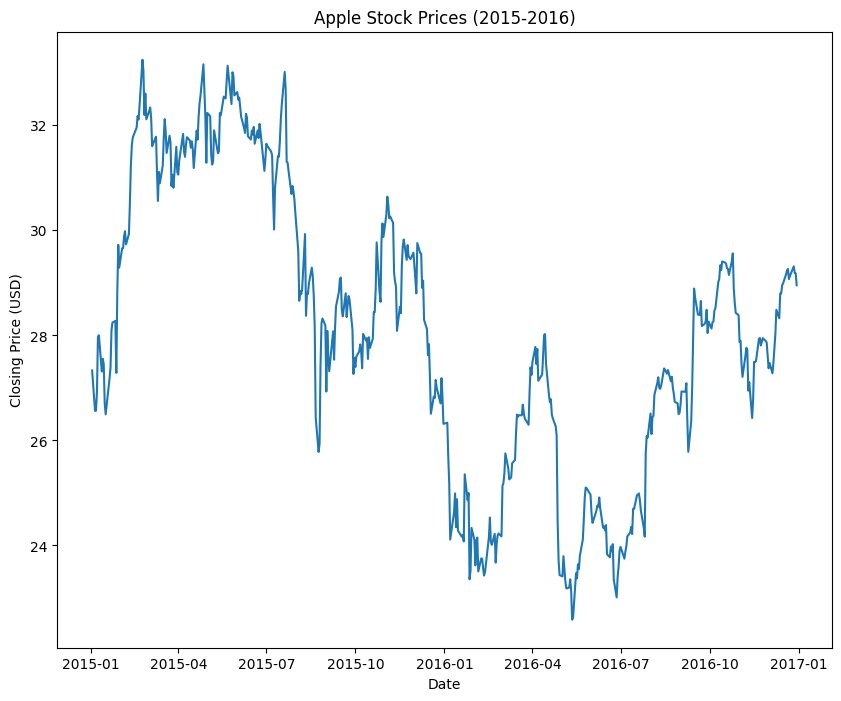

In [24]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import subprocess

# Install yfinance package
subprocess.check_call(['python', '-m', 'pip', 'install', 'yfinance'])
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages

def download_and_plot_apple_stock():
    '''
    This function downloads Apple's stock price between 2015 and 2016, plots it and saves it as a pdf in 'apple_stocks.pdf'
    '''
    # Download Apple's stock price data
    data = yf.download('AAPL', start='2015-01-01', end='2016-12-31')

    # Plot the closing price
    plt.figure(figsize=(10, 8))
    plt.plot(data['Close'])
    plt.title('Apple Stock Prices (2015-2016)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Save the plot as a pdf
    pdf_pages = PdfPages('apple_stocks.pdf')
    pdf_pages.savefig(plt.gcf(), bbox_inches='tight')
    pdf_pages.close()

download_and_plot_apple_stock()